In [1]:
import torch
import requests
from PIL import Image
from diffusers import StableDiffusionDepth2ImgPipeline

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
   "stabilityai/stable-diffusion-2-depth",
   torch_dtype=torch.float16,
).to("cuda")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
init_image = Image.open(requests.get(url, stream=True).raw)

prompt = "two tigers"
n_propmt = "bad, deformed, ugly, bad anotomy"
image = pipe(prompt=prompt, image=init_image, negative_prompt=n_propmt, strength=0.7).images[0]

2023-01-05 20:45:48.758156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 20:45:49.384292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda-11.4/extras/Debugger/lib64:/usr/local/cuda-11.4/extras/Debugger/include
2023-01-05 20:45:49.384351: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [2]:
from transformers import pipeline

estimator = pipeline("depth-estimation")
result = estimator(image)
image.size, result["depth"].size

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/pawel/projekty/aiart/venv/lib/python3.8/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


((640, 480), (640, 480))

In [5]:
import numpy as np


model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

def get_depth(image):
    input_batch = transform(image).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    return prediction.cpu().numpy()
depth = get_depth(np.asarray(image))
depth

Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/pawel/.cache/torch/hub/intel-isl_MiDaS_master


array([[10.697088 , 10.7627735, 10.796997 , ..., 11.686618 , 11.754799 ,
        11.725089 ],
       [10.71157  , 10.741364 , 10.768505 , ..., 11.669832 , 11.703182 ,
        11.702714 ],
       [10.619084 , 10.664203 , 10.683729 , ..., 11.60761  , 11.620394 ,
        11.574566 ],
       ...,
       [28.639748 , 28.659653 , 28.621681 , ..., 26.476011 , 26.475029 ,
        26.476011 ],
       [28.722757 , 28.687538 , 28.647453 , ..., 26.518309 , 26.534002 ,
        26.529078 ],
       [28.714346 , 28.689505 , 28.645689 , ..., 26.594301 , 26.612474 ,
        26.555359 ]], dtype=float32)

  0%|          | 0/35 [00:00<?, ?it/s]

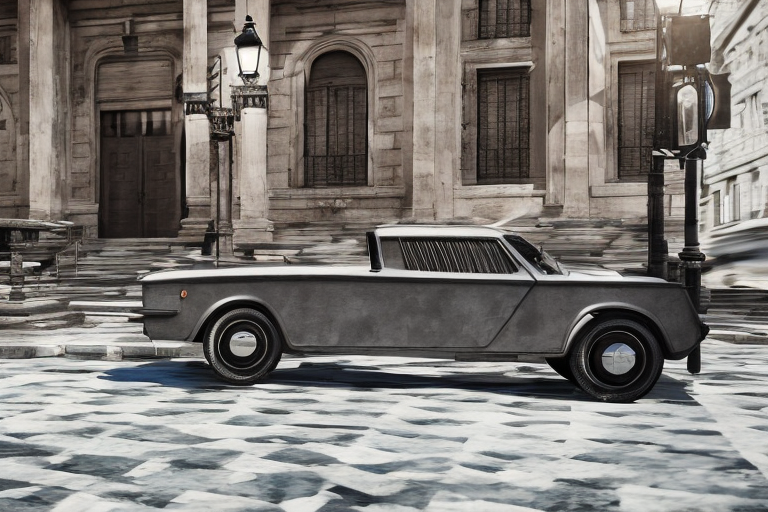

In [10]:
init_img = Image.open("/home/pawel/git/NeuralNetworksSketchbook/car.jpg").convert("RGB")
pipe(prompt=" A photo of a sport car, from the left, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd", image=init_img, negative_prompt=n_propmt, strength=0.7).images[0]